<a href="https://colab.research.google.com/github/Svetorus/Python-Data-Science/blob/master/Coursework_r2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Python для Data Science

## Курсовой проект

**Подключение библиотек и скриптов**

In [0]:
import pandas as pd
import numpy as np
import itertools
import random

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from catboost import Pool, CatBoostRegressor

from sklearn.linear_model import LinearRegression
import xgboost as xgb, lightgbm as lgbm, catboost as catb
from sklearn.metrics import r2_score as r2

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [0]:
import warnings
warnings.simplefilter('ignore')

### Задание:  

Используя данные из train.csv, построить
модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели предсказать
цены для квартир из файла test.csv.

### Целевая переменная:  

Price

In [0]:
# filling values instead of NaN
def fill_nan(df):
    df['LifeSquare'] = df['LifeSquare'].fillna(df['Square'].mean())
    df['Healthcare_1'] = df['Healthcare_1'].fillna(df['Healthcare_1'].mean())
    return df

In [0]:
# changing HouseYear
def clean_year(df):
    df.loc[(~df['HouseYear'].between(1850, 2020)),'HouseYear'] = 1969
    return df

In [0]:
# changing Rooms from 0 
def zero_rooms_change(df):
    df.loc[df['Rooms'] == 0 , 'Rooms'] = df['Square']//20
    df.loc[df['Rooms'] == 0 , 'Rooms'] = 1
    return df

In [0]:
# Kitchensquare cleaning
def clean_kitchensquare(df):
    df.loc[df['KitchenSquare'] > 25,'KitchenSquare'] = 8
    return df

In [0]:
def clean_data(df):
    df = fill_nan(df)
    df = clean_year(df)
    df = zero_rooms_change(df)
    df = clean_kitchensquare(df)

    return df    

In [0]:
# object DataFrame with grouped values
def price_for_meter(df):
    df['PriceForMeter'] = df['Price']/df['Square']
    return df

### Загружаем данные

In [0]:
df_train = pd.read_csv('train.csv')
#data.head()

In [0]:
df_test = pd.read_csv('test.csv')
#test.head()

## Обзор данных

In [0]:
df_train.iloc[0]

Id                   14038
DistrictId              35
Rooms                    2
Square             47.9816
LifeSquare         29.4428
KitchenSquare            6
Floor                    7
HouseFloor               9
HouseYear             1969
Ecology_1        0.0890397
Ecology_2                B
Ecology_3                B
Social_1                33
Social_2              7976
Social_3                 5
Healthcare_1           NaN
Helthcare_2              0
Shops_1                 11
Shops_2                  B
Price               184967
Name: 0, dtype: object

In [0]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

### Количество пропущенных значений (в процентах)

In [0]:
round((len(df_train) - df_train.count()) / len(df_train) * 100, 2).sort_values(ascending=False).head()

Healthcare_1    47.98
LifeSquare      21.13
Price            0.00
HouseYear        0.00
DistrictId       0.00
dtype: float64

### Количество уникальных значений по каждому из признаков

In [0]:
df_train.nunique().sort_values()

Shops_2              2
Ecology_2            2
Ecology_3            2
Helthcare_2          7
Rooms                9
Shops_1             16
Social_3            30
Floor               33
HouseFloor          44
Social_1            51
KitchenSquare       58
Healthcare_1        79
HouseYear           97
Ecology_1          129
Social_2           142
DistrictId         205
LifeSquare        7887
Id               10000
Square           10000
Price            10000
dtype: int64

### Приведение типов

In [0]:
df_train.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

### Анализ целевой переменной

### Анализ линейных зависимостей в признаковом пространстве

df=df_train
plt.figure(figsize=(25,18), dpi= 80)
sns.heatmap(df.corr(), xticklabels=df.corr().columns, yticklabels=df.corr().columns, cmap='RdYlGn', center=0, annot=True)

#### Decorations
plt.title('Correlation matrix', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

### Смотрим зависимости между фичами

In [0]:
import numpy as np
from catboost import Pool, CatBoostRegressor
cat_features = [i for i, (col, ser) in enumerate(df_train.iteritems()) if ser.dtype == object]
pool = Pool(data=df_train.iloc[:, :-1], label=df_train.iloc[:, -1], cat_features=cat_features)

model = CatBoostRegressor(iterations=100, 
                          depth=2,silent=True, 
                          loss_function='RMSE')

model.fit(pool)

preds = model.get_feature_importance(data=pool, type='Interaction')
#print(preds)

for i in range(len(preds)):
    print(i)
    if type(preds[i]) is list:
        print(i)

In [0]:
data_new_fichy = pd.DataFrame({'f_col':[i[0] for i in preds],
                  's_col':[i[1] for i in preds],
                  'interest':[i[2] for i in preds]})

In [0]:
number_fich = dict(enumerate(df_train.iloc[0:0,1:].columns, start=1))
for i in data_new_fichy['f_col']:
    if i in number_fich:
        data_new_fichy.loc[data_new_fichy['f_col']==i,'f_col']=number_fich[i]
for i in data_new_fichy['s_col']:
    if i in number_fich:
        data_new_fichy.loc[data_new_fichy['s_col']==i,'s_col']=number_fich[i]      
data_new_fichy.head(12)

,f_col,s_col,interest
0,Square,Social_1,18.754763
1,Square,Social_2,18.438336
2,Square,Social_3,11.606640
3,Square,Shops_1,10.489579
4,DistrictId,Square,9.364158
5,DistrictId,Social_3,3.530451
6,Ecology_1,Social_3,3.376996
7,Rooms,KitchenSquare,3.328072
8,Square,Ecology_1,3.271021
9,Square,KitchenSquare,2.781320


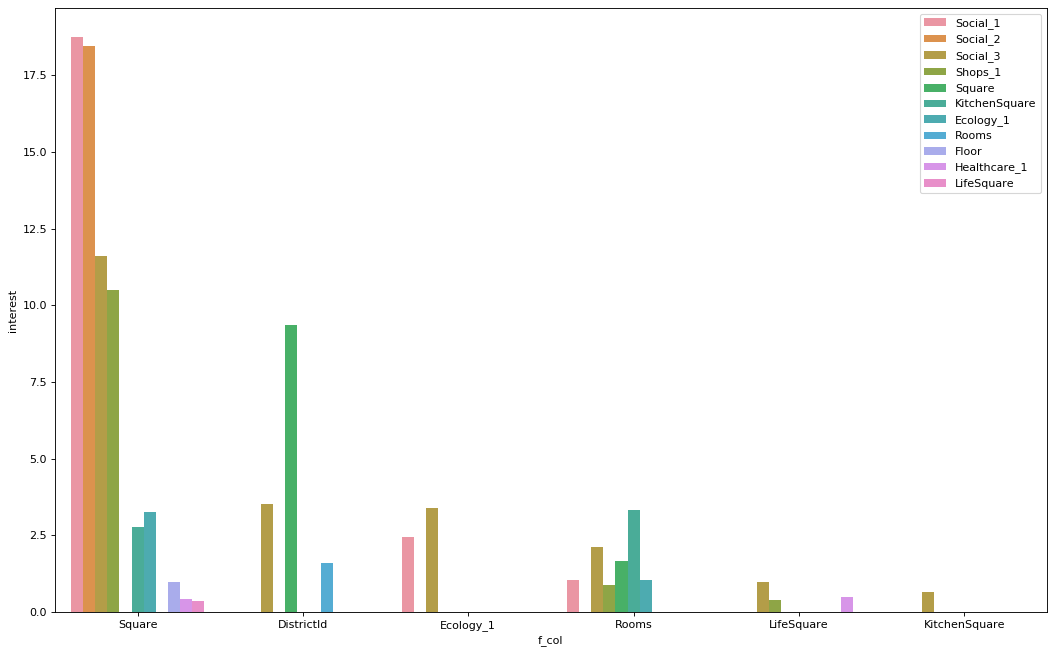

In [0]:
fig = plt.figure(figsize=(16, 10), dpi= 80)
sns.barplot(x='f_col', y='interest', hue='s_col', data=data_new_fichy)
plt.legend(loc='upper right');

### test split

In [0]:
train, valid = train_test_split(df_train,  test_size=0.3, random_state=42)

### Target(Price)

In [0]:
y_train = pd.DataFrame(train['Price'])
y_valid = pd.DataFrame(valid['Price'])

### Обработка данных

In [0]:
# Train
# Price For Meter column added
flats_prices = price_for_meter(train)

In [0]:
flats_prices_clean = clean_data(flats_prices)

In [0]:
# Valid
flats_prices_valid_clean = valid.drop('Price', axis = 1)

In [0]:
flats_prices_valid_clean = clean_data(flats_prices_valid_clean)

In [0]:
# Test
df_test = clean_data(df_test)

In [0]:
# adding a column with mean price for square meter in each district to train and valid datasets
district_mean_priceformeter = flats_prices_clean.groupby('DistrictId', as_index=False)['PriceForMeter'].mean().rename\
            (columns={'PriceForMeter': 'MeanPricePerMeterDist'})
flats_prices_clean = pd.merge(flats_prices_clean, district_mean_priceformeter, on='DistrictId', how='left')
flats_prices_valid_clean = pd.merge(flats_prices_valid_clean, district_mean_priceformeter, on='DistrictId', how='left')

In [0]:
# Test
# adding a column with mean price for square meter in each district to test dataset
df_test = pd.merge(df_test, district_mean_priceformeter, on='DistrictId', how='left')

In [0]:
# Train
# Drop Price and Price For Meter
flats_prices_clean = flats_prices_clean.drop('Price', axis = 1)
flats_prices_clean = flats_prices_clean.drop('PriceForMeter', axis = 1)

In [0]:
# Train dummies
flats_prices_clean = pd.get_dummies(flats_prices_clean)
feats = flats_prices_clean.columns

In [0]:
# valid
flats_prices_valid_clean['MeanPricePerMeterDist'] = flats_prices_valid_clean['MeanPricePerMeterDist'].fillna(flats_prices_valid_clean['MeanPricePerMeterDist'].mean())

In [0]:
# Test
df_test['MeanPricePerMeterDist'] =  df_test['MeanPricePerMeterDist'].fillna(df_test['MeanPricePerMeterDist'].mean())

In [0]:
# valid dummies
flats_prices_valid_clean = pd.get_dummies(flats_prices_valid_clean)

In [0]:
# Test dummies
df_test = pd.get_dummies(df_test)

### RandomForestRegressor

In [0]:
rfr = RandomForestRegressor(max_depth=21, max_features=4, n_estimators=250, random_state=42)

In [0]:
rfr.fit(flats_prices_clean, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=21, max_features=4, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=250, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [0]:
y_pred_clean = rfr.predict(flats_prices_valid_clean)

In [0]:
np.array(cross_val_score(rfr, flats_prices_clean, y_train, cv=5)).mean()

0.758333049230461

In [0]:
r2(y_valid, y_pred_clean)

0.733660075644984